# Elo Merchant Category Recommendation - Dimension reduction
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [141]:
import os
import gc
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
from ggplot import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
%matplotlib inline

random.seed(1)
threshold = 0.5

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Input
### Transactions and merchant aggregations

In [3]:
df_new_trans = pd.read_csv("input/trans_merch_new_agg.csv")
print("{:,} records and {} features in new aggregation set.".format(df_new_trans.shape[0], df_new_trans.shape[1]))

df_new_trans = reduce_mem_usage(df_new_trans)

290,001 records and 112 features in new aggregation set.
Starting memory usage: 247.80 MB
Reduced memory usage: 60.02 MB (75.8% reduction)


In [4]:
df_hist_trans = pd.read_csv("input/trans_merch_hist_agg.csv")
print("{:,} records and {} features in historical aggregation set.".format(df_hist_trans.shape[0], df_hist_trans.shape[1]))

df_hist_trans = reduce_mem_usage(df_hist_trans)

325,540 records and 112 features in historical aggregation set.
Starting memory usage: 278.17 MB
Reduced memory usage: 83.20 MB (70.1% reduction)


### Train and test data

In [5]:
df_train = pd.read_csv("input/train.csv")
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))
df_test = reduce_mem_usage(df_test)

201,917 records and 6 features in train set.
Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
123,623 records and 5 features in test set.
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


### Merging

In [6]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

In [7]:
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [8]:
del df_hist_trans
del df_new_trans
gc.collect()

35

In [9]:
df_train.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

In [13]:
df_train.dropna(how='any', axis=0, inplace=True)
df_test.dropna(how='any', axis=0, inplace=True)

## Dimension reduction
Source: [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [10]:
print('Initial number of features: {}'.format(df_train.shape[1]))

Initial number of features: 226


In [11]:
for i in df_train.columns:
    if (df_train[i].dtype == 'float64') or (df_train[i].dtype == 'float32'):
        print('{} converted to float16'.format(i))
        df_train[i] = df_train[i].astype(np.float16)

hist_active_months_lag12_sum converted to float16
hist_avg_sales_lag3_sum converted to float16
hist_avg_sales_lag3_mean converted to float16
hist_avg_sales_lag6_sum converted to float16
hist_avg_sales_lag6_mean converted to float16
hist_avg_sales_lag12_sum converted to float16
hist_avg_sales_lag12_mean converted to float16
hist_avg_purchases_lag3_sum converted to float16
hist_avg_purchases_lag3_mean converted to float16
hist_avg_purchases_lag6_sum converted to float16
hist_avg_purchases_lag6_mean converted to float16
hist_avg_purchases_lag12_sum converted to float16
hist_avg_purchases_lag12_mean converted to float16
hist_purchase_amount_sum converted to float16
hist_purchase_amount_mean converted to float16
hist_purchase_amount_max converted to float16
hist_purchase_amount_std converted to float16
new_transactions_count converted to float16
new_authorized_flag_sum converted to float16
new_authorized_flag_mean converted to float16
new_avg_sales_lag3_sum converted to float16
new_avg_sale

In [ ]:
for i in df_test.columns:
    if (df_test[i].dtype == 'float64') or (df_test[i].dtype == 'float32'):
        print('{} converted to float16'.format(i))
        df_test[i] = df_test[i].astype(np.float16)

In [162]:
features = ['feature_1', 'feature_2', 'feature_3', 'hist_transactions_count', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_active_months_lag3_sum', 'hist_active_months_lag3_mean', 'hist_active_months_lag6_sum', 'hist_active_months_lag6_mean', 'hist_active_months_lag12_sum', 'hist_active_months_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_3_sum', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_group_id_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_month_lag_min', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_group_id_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_mean', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_min', 'hist_most_recent_sales_range_std', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_mean', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_min', 'hist_most_recent_purchases_range_std', 'hist_numerical_1_mean', 'hist_numerical_1_median', 'hist_numerical_1_max', 'hist_numerical_1_min', 'hist_numerical_1_std', 'hist_numerical_2_mean', 'hist_numerical_2_median', 'hist_numerical_2_max', 'hist_numerical_2_min', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_merch_nunique', 'new_subsector_id_merch_nunique', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_std', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_std', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_std', 'new_installments_std', 'new_merchant_id_nunique', 'new_merchant_category_id_trans_nunique', 'new_merchant_group_id_nunique', 'new_merchant_category_id_merch_nunique', 'new_month_lag_min', 'new_month_lag_max', 'new_month_lag_mean', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_mean', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_min', 'new_most_recent_sales_range_std', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_mean', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_std', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_min', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_min', 'new_numerical_2_std', 'new_state_id_nunique', 'new_subsector_id_trans_nunique']

### PCA

In [146]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(df_train[features].values)

df_train['pca_1'] = pca_result[:,0]
df_train['pca_2'] = pca_result[:,1] 
df_train['pca_3'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [9.51767003e-01 2.86570082e-02 9.17702181e-03 3.57909307e-03
 2.57745041e-03 1.16029212e-03 1.02493039e-03 4.94834852e-04
 3.34673179e-04 2.84458301e-04 1.64295708e-04 1.43972475e-04
 1.23285985e-04 9.31949186e-05 6.86230833e-05 6.48193762e-05
 4.76005527e-05 3.50381161e-05 3.28910023e-05 3.04095944e-05]


In [139]:
rndperm = np.random.permutation(df_train.shape[0])

df_train['is_outlier'] = df_train['target'].apply(lambda x: 1 if x < -30 else 0)

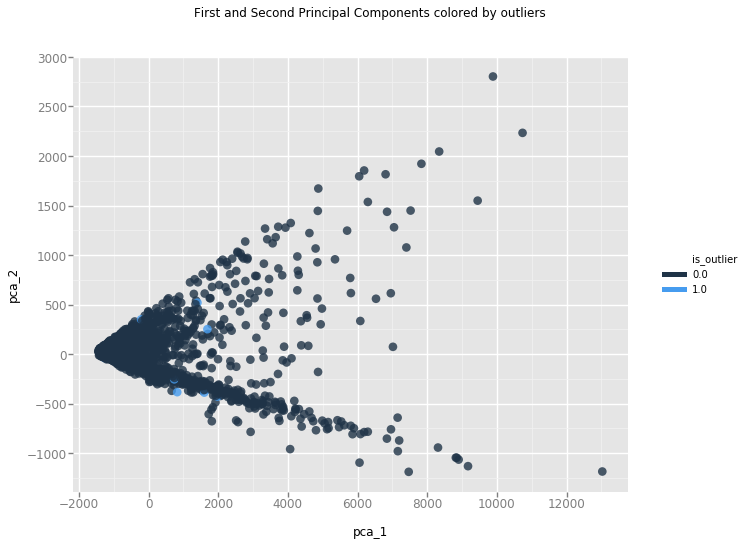

<ggplot: (-9223372036836689250)>

In [140]:
chart = ggplot(df_train.loc[rndperm[:3000], :], aes(x='pca_1', y='pca_2', color='is_outlier') ) \
        + geom_point(size=75, alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by outliers")
    
chart

### t-SNE

In [157]:
df_train[features][:3]

,feature_1,feature_2,feature_3
0,5,2,1
1,4,1,0
3,4,3,0


In [168]:
n_sne = 3000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) #rndperm[:n_sne]
tsne_results = tsne.fit_transform(df_train.loc[:10000, features].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7304 samples in 0.083s...
[t-SNE] Computed neighbors for 7304 samples in 3.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7304
[t-SNE] Computed conditional probabilities for sample 2000 / 7304
[t-SNE] Computed conditional probabilities for sample 3000 / 7304
[t-SNE] Computed conditional probabilities for sample 4000 / 7304
[t-SNE] Computed conditional probabilities for sample 5000 / 7304
[t-SNE] Computed conditional probabilities for sample 6000 / 7304
[t-SNE] Computed conditional probabilities for sample 7000 / 7304
[t-SNE] Computed conditional probabilities for sample 7304 / 7304
[t-SNE] Mean sigma: 30.847784
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.319145
[t-SNE] Error after 300 iterations: 2.021568


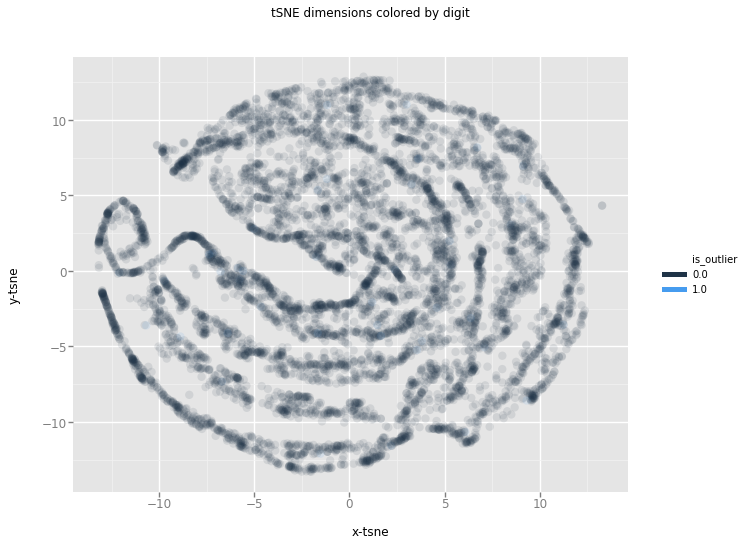

<ggplot: (17939688)>

In [169]:
df_tsne = df_train.loc[:10000,:].copy() # rndperm[:n_sne]
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='is_outlier') ) \
        + geom_point(size=70, alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart